# Implementing an QFT Adder on a quantum computer

This is an example of QFT-based Adder. 

For two quantum states holding an integer $a$ and $b$, the goal is to develop an add algorithm that does

$Add\left|a\right>\left|b\right>=\left|a\right>\left|a+b\right>$

Recall that the quantum Fourier transform is defined as
$QFT\left|a\right>=\frac{1}{2^n}\sum_{j=0}^{2^n-1}{e^{2\pi ija/2^n}\left|j\right>}$

Define
$\left|\phi_k(a)\right>=\frac{1}{\sqrt 2}\left(\left|0\right>+e^{2\pi ia/2^k}\left|1\right>\right)$

QFT could be written as
$QFT\left|a\right>=\left|\phi_1(a)\right>\otimes\left|\phi_2(a)\right>\otimes...\otimes\left|\phi_n(a)\right>$

$a+b$ could be obtained by 
$\left|a+b\right>=QFT^{-1}\left|\phi_1(a+b)\right>\otimes...\otimes\left|\phi_n(a+b)\right>$

Now the question is, how do we obtain $\left|\phi_k(a+b)\right>$ given $\left|\phi_k(b)\right>$? 

$\left|\phi_k(a+b)\right>=\frac{1}{\sqrt 2}\left(\left|0\right>+e^{2\pi i(a+b)/2^k}\left|1\right>\right)$

Suppose $a = a_1\cdot 2^{m-1}+a_2\cdot 2^{m-2}+...+a_{m}\cdot 2^0$, 
and $b = b_1\cdot 2^{n-1}+b_2\cdot 2^{n-2}+...+b_{n}\cdot 2^0$

Then $\left|\phi_k(a+b)\right>=\frac{1}{\sqrt 2}\left(\left|0\right>+e^{2\pi ia/2^k}e^{2\pi ib/2^k}\left|1\right>\right)$

Let's now compute $\mathrm{exp}(2\pi ia/2^k)=\mathrm{exp}\left(2\pi i\left(a_1\cdot 2^{m-1-k}+a_2\cdot 2^{m-2-k}+...+a_m\cdot 2^{-k}\right)\right)=\mathrm{exp}\left(2\pi i\left(a_{m-k+1}/2+a_{m-k+2}/2^2+...+a_m/2^{k}\right)\right)=\mathrm{exp}\left(2\pi i0.a_{m-k+1}a_{m-k+2}...a_m\right)$

This phase could be encoded by series of controlled-phase rotation targeted at the $k$th qubit in $b$ and controlled by the $(m-k+1)$th, $(m-k+2)$th, ..., $m$th qubit in $a$. 

Overall, the QFT Adder works as the following:

1. Initialize two registers to $a$ and $b$. 
2. Perform QFT on $b$. 
3. Perform controlled phase rotations on $b$ controlled by $a$. 
4. Perform inverse QFT on $b$. 
5. Measure $a$ and $b$. Now $b$ should become $a+b$, and $a$ should stay the same. 

## Setup

First, make sure that you have the latest version of Qiskit installed. To upgrade your Qiskit package, run the following command:

```bash
pip install --upgrade qiskit
```

Get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the python package `qiskit_ionq` using `pip`:

```bash
pip install qiskit_ionq
```

(IonQ's adapter for Qiskit is currently in private beta -- your feedback is welcomed!)

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [47]:
# import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit.library import QFT

from qiskit_ionq import IonQProvider 

#Call provider and set token value
provider = IonQProvider(token='my token')

# numpy
import numpy as np

# plotting
from matplotlib import pyplot as plt
%matplotlib inline 

The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:

In [41]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

### Let's implement QFT and its inverse

Let us create two circuits that implement the quantum Fourier transform and its inverse for a given number of qubits (n). 

In [34]:
# Quantum Fourier transform of |q>, of length n.
def qft(circ, q, n):
    # Loop through the target qubits.
    for i in range(n,0,-1):
        # Apply the H gate to the target.
        circ.h(q[i-1])

        # Loop through the control qubits.
        for j in range(i-1,0,-1):
            circ.cp(2*np.pi/2**(i-j+1), q[j-1], q[i-1])

# Inverse Fourier transform of |q>, of length n.
def iqft(circ, q, n):
    # Loop through the target qubits.
    for i in range(1,n+1):
        # Loop through the control qubits.
        for j in range(1,i):
            # The inverse Fourier transform just uses a negative phase.
            circ.cp(-2*np.pi/2**(i-j+1), q[j-1], q[i-1])

        # Apply the H gate to the target.
        circ.h(q[i-1])


### Let's implement QFT Adder

Let us create the circuit that implement the QFT Adder. 

In [ ]:
# define the Add function
def Add(circ, a, b, n):
    
    # add 1 to n to account for overflow
    n += 1
    
    # take the QFT
    qft(circ, b, n)
    
    circ.barrier()
    
    # Compute the controlled phases 
    # Iterate over targets 
    for i in range(n, 0, -1):
        # Iterate over controls
        for j in range(i, 0, -1):
            # If the qubit a[j-1] exists run cp, if not assume the qubit is 0 and never existed
            if len(a) - 1 >= j - 1:
                circ.cp(2*np.pi/2**(i-j+1), a[j-1], b[i-1])
    
    circ.barrier()
    
    # take the inverse QFT
    iqft(circ, b, n)

### Let's now add numbers

Finally, we have everything we need to perform $a+b$ on a quantum computer. Let's now add $a=10 (2)$ to $b=001 (1)$, and the ideal result should be $011 (3)$  

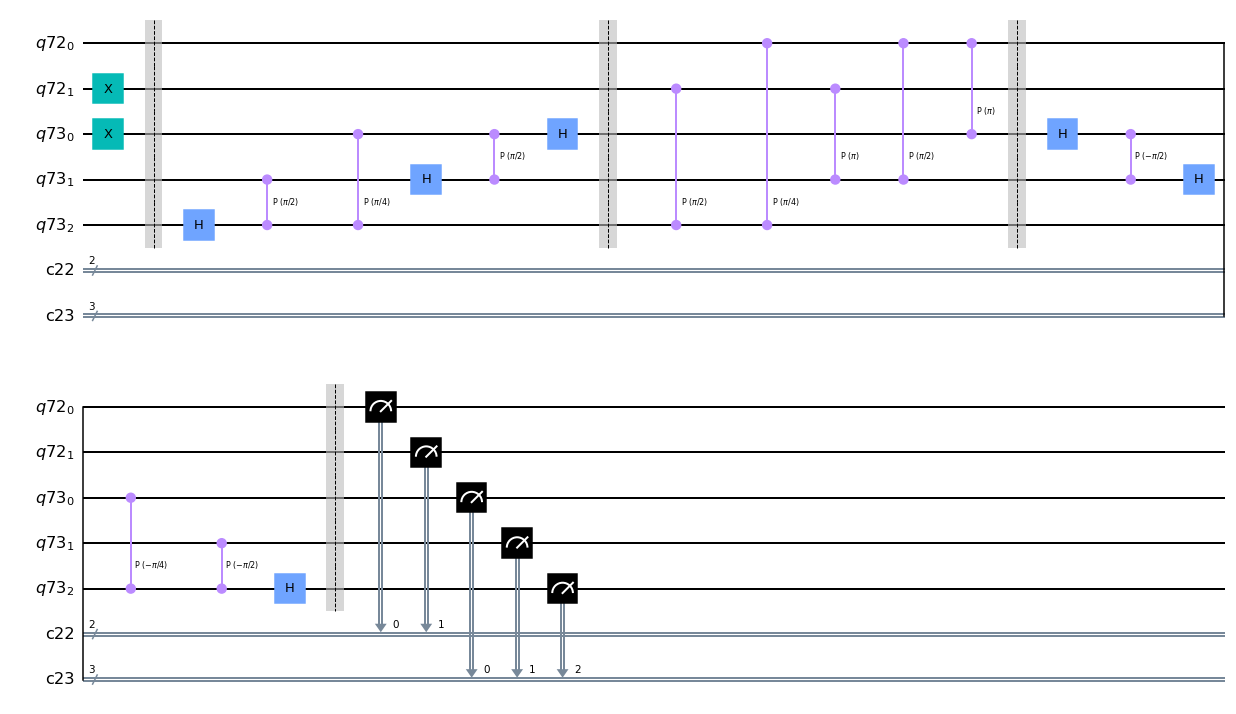

In [48]:
# Registers and circuit.
a = QuantumRegister(2)
b = QuantumRegister(3)
ca = ClassicalRegister(2)
cb = ClassicalRegister(3)
qc = QuantumCircuit(a, b, ca, cb)

# Numbers to add.
qc.x(a[1]) # a = 01110 / a = 10
#qc.x(a[2])
#qc.x(a[3])
qc.x(b[0]) # b = 01011 / b = 001
#qc.x(b[1])
#qc.x(b[3])

qc.barrier()

# Add the numbers, so |a>|b> to |a>|a+b>.
Add(qc, a, b, 2)

qc.barrier()

# Measure the results.
qc.measure(a, ca)
qc.measure(b, cb)

qc.draw(output="mpl")

### Let's look at the ideal outcomes

In [46]:
# simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
job_sim   = execute(qc, simulator)
result_sim = job_sim.result()

print(result_sim.get_counts(qc))

{'011 10': 1024}


Great! We obtain the correct result!

### Running jobs on a quantum computer

We are now ready to submit the jobs on IonQ's QPUs. Since actual quantum computers are noisy, the quality of the output state probabilities decreases with the number of gates favoring fully connected architectures over the ones with limited connectivity.

In [49]:
# run the circuit on a real-device
qpu = provider.get_backend("ionq_qpu")
qpu_job = qpu.run(qc)


from qiskit.providers.jobstatus import JobStatus
import time
# Check if job is done
while qpu_job.status() is not JobStatus.DONE:
    print("Job status is", qpu_job.status() )
    time.sleep(60)


Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job stat

NameError: name 'bv_job' is not defined

In [51]:
# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", qpu_job.status() )
print(qpu_job.get_counts()) # these counts are the “true” counts from the actual QPU Run

result_exp = qpu_job.result()

Job status is JobStatus.DONE
{'000 00': 5, '000 01': 2, '000 10': 7, '000 11': 3, '001 00': 20, '001 01': 1, '001 10': 46, '001 11': 4, '010 00': 1, '010 01': 2, '010 10': 56, '010 11': 17, '011 00': 24, '011 10': 600, '011 11': 5, '100 00': 4, '100 10': 13, '100 11': 10, '101 00': 15, '101 01': 1, '101 10': 61, '110 00': 1, '110 01': 1, '110 10': 10, '110 11': 4, '111 00': 2, '111 10': 104, '111 11': 5}


This is a bit messy. Let's plot the histogram. 

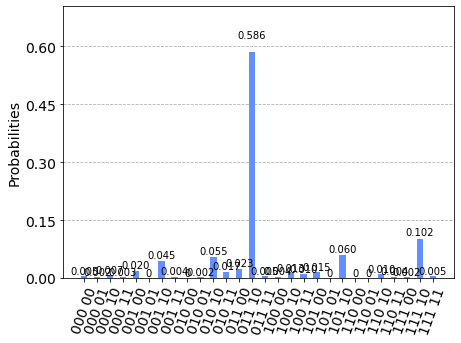

In [53]:
from qiskit.visualization import plot_histogram

plot_histogram(qpu_job.get_counts())

Great! The expected result is of the largest probability!